# EE3020 Assignment 1

# 1. Import Libraries:

In [46]:
import pandas as pd # Import pandas library for data manipulation.
import numpy as np # Import numpy to use np arrays in sklearn models.
import matplotlib.pyplot as plt # Import matplotlib for generating plots.
import regex as re # Import regular expressions to convert dates in HSE csv file.
from scipy import signal # Import scipy.signal to use cross correlation function for time lag.
from scipy.stats import spearmanr # Spearman's correlation coefficient to look at strength of monotonic relationship between cases and deaths.
from scipy.stats import pearsonr # Pearson's correlation coefficient to look at strength of linear relationship between cases and deaths.
from sklearn.linear_model import LinearRegression # Import LinearRegression to perform a linear regression.
from sklearn.model_selection import train_test_split # Import train_test_split to do a random 80/20 split on data from 01/06/20 to create a training and validation set.
from sklearn.metrics import mean_squared_error # Import mean_squared_error to calculate the RMSE for the regression models.
from sklearn.preprocessing import PolynomialFeatures # Import PolynomialFeatures to transform Deaths array for Polynomial Regression.
from sklearn.pipeline import Pipeline # Import sklearn's Pipeline object so that that a gridsearch can be performed on PolynomialFeatures to determined the best model for polynomial regression.
from sklearn.model_selection import GridSearchCV # Import sklearn's GridSearchCV to perform k-fold cross validation to determine the best degree for the polynomial regression model.
from sklearn.preprocessing import StandardScaler # Import sklearn's StandardScaler transformer to standardise the dataset before fitting the SVM.
from sklearn.svm import SVR # Import Support Vector Regressor model.
from sklearn.model_selection import cross_val_score # Import sklearn's cross_val_score to perform 5 fold cross validation on the training set.

# 2. Read in data from .csv:

In [47]:
data_path = "CovidStatisticsProfileHPSCIrelandOpenData.csv" # Path to csv from HSE website.
covid_data = pd.read_csv(data_path) # Read in csv file as a pandas dataframe.

# 3. Use regex to parse date-time strings into just dates:

In [48]:
pattern = r'[0-9]+/[0-9]+/[0-9]+[0-9]' # regex pattern to match dates in the form 'number/number/number'.
regex = re.compile(pattern) # Compile regex to save CPU cycles when applying it to many strings.

covid_data.Date = covid_data.Date.map(regex.findall) # Returns all strings matching regex pattern in 'Date' column.
covid_data.Date = covid_data.Date.map(''.join) # Convert matched regex 'Date' patterns from list to string.
covid_data.set_index('Date',inplace=True) # Set new parsed dates as index to the dataframe.
covid_data # Inspect dataframe.

,X,Y,ConfirmedCovidCases,TotalConfirmedCovidCases,ConfirmedCovidDeaths,TotalCovidDeaths,StatisticsProfileDate,CovidCasesConfirmed,HospitalisedCovidCases,RequiringICUCovidCases,...,Aged25to34,Aged35to44,Aged45to54,Aged55to64,Aged65up,Median_Age,CommunityTransmission,CloseContact,TravelAbroad,FID
Date,,,,,,,,,,,,,,,,,,,,,
2020/02/29,-7.692596,53.288234,1,1,0,0,2020/02/27 00:00:00+00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2020/03/03,-7.692596,53.288234,1,2,0,0,2020/03/01 00:00:00+00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
2020/03/04,-7.692596,53.288234,4,6,0,0,2020/03/02 00:00:00+00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
2020/03/05,-7.692596,53.288234,7,13,0,0,2020/03/03 00:00:00+00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
2020/03/06,-7.692596,53.288234,5,18,0,0,2020/03/04 00:00:00+00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021/02/26,-7.692596,53.288234,776,218251,29,4300,2021/02/24 00:00:00+00,217475.0,12789.0,1291.0,...,38614.0,34942.0,32814.0,24823.0,28935.0,38.0,44.0,55.0,1.0,362
2021/02/27,-7.692596,53.288234,738,218980,13,4313,2021/02/25 00:00:00+00,218242.0,12837.0,1292.0,...,38739.0,35063.0,32944.0,24865.0,29018.0,38.0,44.0,55.0,1.0,363
2021/02/28,-7.692596,53.288234,612,219592,6,4319,2021/02/26 00:00:00+00,218980.0,12882.0,1297.0,...,38873.0,35172.0,33029.0,24932.0,29079.0,38.0,44.0,56.0,1.0,364


# 4. Remove data from 01/03/20 - 31/05/20:

Creating a training/validation set consisting of data from 01/06/20 - Present.

In [49]:
covid_data_valid = covid_data.loc['2020/06/01':,:] # Store training & validation data from 1st June to now in covid_data_valid.
covid_data_valid # Inspect dataframe.

,X,Y,ConfirmedCovidCases,TotalConfirmedCovidCases,ConfirmedCovidDeaths,TotalCovidDeaths,StatisticsProfileDate,CovidCasesConfirmed,HospitalisedCovidCases,RequiringICUCovidCases,...,Aged25to34,Aged35to44,Aged45to54,Aged55to64,Aged65up,Median_Age,CommunityTransmission,CloseContact,TravelAbroad,FID
Date,,,,,,,,,,,,,,,,,,,,,
2020/06/01,-7.692596,53.288234,77,25062,1,1650,2020/05/30 00:00:00+00,24985.0,3286.0,408.0,...,4197.0,4399.0,4488.0,3204.0,6380.0,48.0,39.0,58.0,2.0,92
2020/06/02,-7.692596,53.288234,10,25066,8,1658,2020/05/31 00:00:00+00,25056.0,3292.0,408.0,...,4205.0,4407.0,4502.0,3213.0,6391.0,48.0,39.0,58.0,2.0,93
2020/06/03,-7.692596,53.288234,47,25111,3,1659,2020/06/01 00:00:00+00,25064.0,3298.0,409.0,...,4207.0,4407.0,4503.0,3213.0,6395.0,48.0,39.0,59.0,2.0,94
2020/06/04,-7.692596,53.288234,38,25142,5,1664,2020/06/02 00:00:00+00,25104.0,3311.0,410.0,...,4209.0,4416.0,4511.0,3221.0,6407.0,48.0,39.0,59.0,2.0,95
2020/06/05,-7.692596,53.288234,28,25163,7,1670,2020/06/03 00:00:00+00,25135.0,3312.0,410.0,...,4211.0,4424.0,4522.0,3227.0,6404.0,48.0,39.0,59.0,2.0,96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021/02/26,-7.692596,53.288234,776,218251,29,4300,2021/02/24 00:00:00+00,217475.0,12789.0,1291.0,...,38614.0,34942.0,32814.0,24823.0,28935.0,38.0,44.0,55.0,1.0,362
2021/02/27,-7.692596,53.288234,738,218980,13,4313,2021/02/25 00:00:00+00,218242.0,12837.0,1292.0,...,38739.0,35063.0,32944.0,24865.0,29018.0,38.0,44.0,55.0,1.0,363
2021/02/28,-7.692596,53.288234,612,219592,6,4319,2021/02/26 00:00:00+00,218980.0,12882.0,1297.0,...,38873.0,35172.0,33029.0,24932.0,29079.0,38.0,44.0,56.0,1.0,364


## Obtain 7 day average and instantaneous values for Cases and Deaths:

Code for calculating rolling 7-day average taken from the provided Jupyter notebook.

In [50]:
inst_cases_deaths_df = covid_data_valid.loc[:,['ConfirmedCovidDeaths','ConfirmedCovidCases']] # Create a new dataframe with cases and deaths as the only columns and the date as the index.
inst_cases_deaths_df.rename(columns={'ConfirmedCovidDeaths':'Deaths',
                                     'ConfirmedCovidCases':'Cases'},inplace=True) # Rename cases and deaths columns to 'Cases' and 'Deaths' for convenience.
inst_cases_deaths_df # Inspect dataframe.

,Deaths,Cases
Date,,
2020/06/01,1,77
2020/06/02,8,10
2020/06/03,3,47
2020/06/04,5,38
2020/06/05,7,28
...,...,...
2021/02/26,29,776
2021/02/27,13,738
2021/02/28,6,612


In [51]:
ave7_cases_deaths_df = inst_cases_deaths_df.copy() # Make a copy of inst_cases_deaths_df to calculate the 7-day average of cases and deaths.
ave7_cases_deaths_df.Cases = inst_cases_deaths_df.Cases.rolling(window=7,min_periods=1).mean() # Calculate 7 day average of cases and assign to the 'Cases' column of ave7_cases_deaths_df.
ave7_cases_deaths_df.Deaths = inst_cases_deaths_df.Deaths.rolling(window=7,min_periods=1).mean() # Calculate 7 day average of deaths and assign to the 'Deaths' column of ave7_cases_deaths_df.
ave7_cases_deaths_df # Inspect dataframe.

,Deaths,Cases
Date,,
2020/06/01,1.000000,77.000000
2020/06/02,4.500000,43.500000
2020/06/03,4.000000,44.666667
2020/06/04,4.250000,43.000000
2020/06/05,4.800000,40.000000
...,...,...
2021/02/26,27.571429,698.714286
2021/02/27,25.714286,663.000000
2021/02/28,26.428571,653.428571


# 5. Plot all cases and deaths from 01/06/20 - Present:

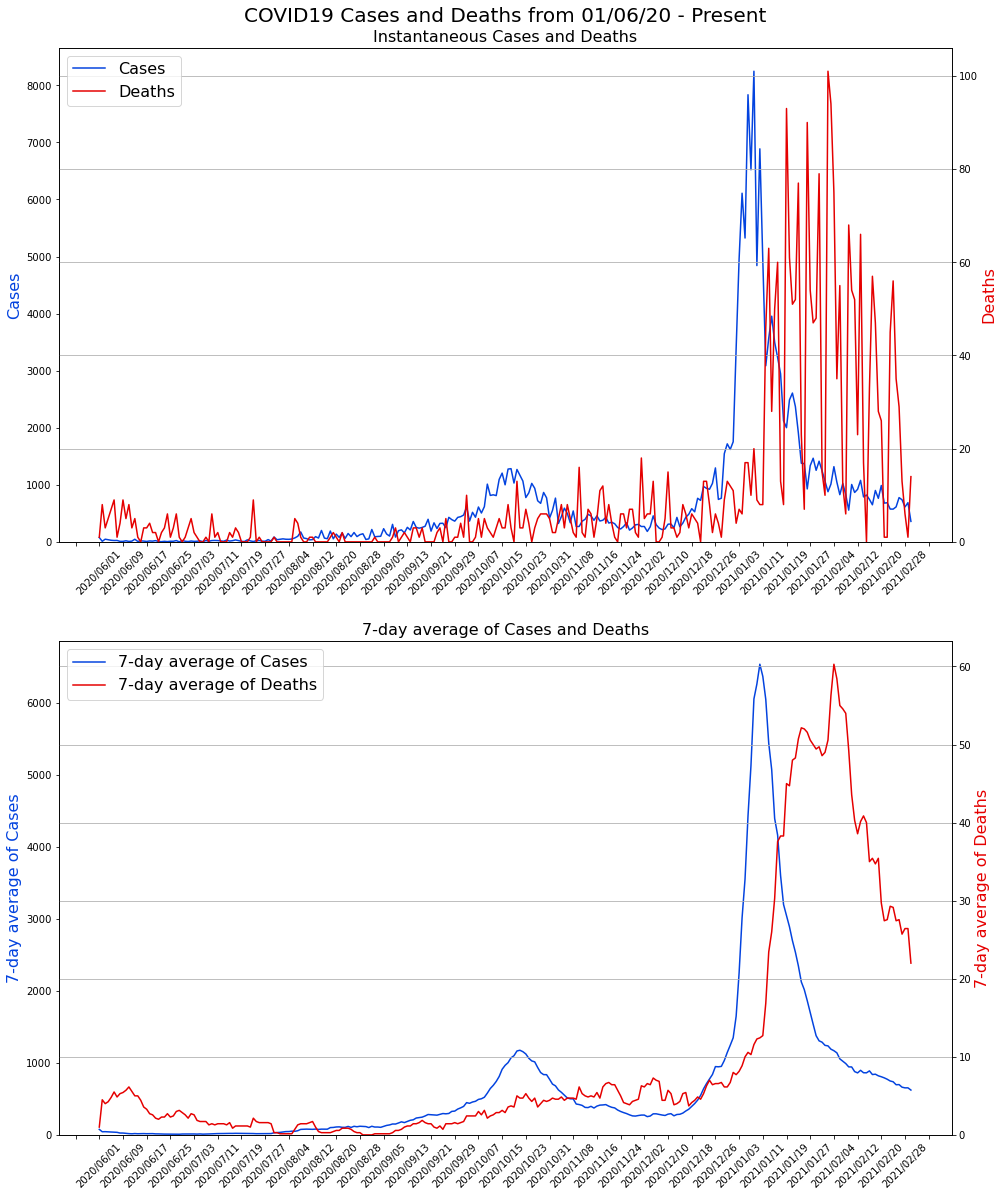

In [52]:
num_ticks = len(inst_cases_deaths_df.index)//7 # Calculate number of ticks to give a tick at approximately every 1 week interval on the x axis.
fig,ax = plt.subplots(nrows = 2, ncols = 1, figsize=(16,20)) # Subplots to make 2 plots (nrows=2,ncols=1) with a figure size of 16x20.

# ==============================================
# First plot for instantaneous cases and deaths:
# ==============================================

cases_trace = ax[0].plot(inst_cases_deaths_df.Cases,color='xkcd:blue',label='Cases') # Plot Cases data. Dates are plot on the x axis as the dates are the index of the DF.
ax[0].set_ylabel('Cases',color='xkcd:blue',fontsize=16) # Set left hand yaxis label to 'Cases'.
ax[0].set_ylim(bottom=0) # Limit the y axis ('Cases') to start at 0.
ax[0].xaxis.set_major_locator(plt.MaxNLocator(num_ticks)) # Set the number of ticks on the x axis to num_ticks (ticks @ approx. 1 week intervals).
labels = ax[0].get_xticklabels() # Return tick labels (Dates) as an object so that they can be rotated.
ax[0].set_xticklabels(labels,rotation=45) # Rotate x axis labels @ 45 degrees.

ax2 = ax[0].twinx() # Create a second y axis on the right hand side of the plot using the same x axis.
deaths_trace = ax2.plot(inst_cases_deaths_df.Deaths,color='xkcd:red',label='Deaths') # Plot Deaths data, dates on x axis.
ax2.set_ylabel('Deaths',color='xkcd:red',fontsize=16) # Set right hand yaxis label to 'Deaths'.
ax2.set_ylim(bottom=0) # Limit the right-hand y axis ('Deaths') to start at 0.
ax2.grid() # Plot a grid for the right hand y axis.
ax2.legend(cases_trace + deaths_trace, ['Cases','Deaths'], fontsize=16, loc='best') # Create legend for Cases and Deaths traces in the best location as determined by matplotlib.
xticks = ax2.xaxis.set_major_locator(plt.MaxNLocator(num_ticks)) # Limit number of ticks on x axis to num_ticks (~1 week intervals).
ax[0].set_title('Instantaneous Cases and Deaths',fontsize=16) # Sub-title for 1st plot for the instantaneous cases and deaths.

plt.title('COVID19 Cases and Deaths from 01/06/20 - Present',fontsize=20,y=1.04) # Set major title for both plots. y=1.04 positions the title so that it doesn't overlap with the minor titles.

# ==================================================
# Second plot for 7-day average of cases and deaths:
# ==================================================

ave7_cases_trace = ax[1].plot(ave7_cases_deaths_df.Cases,color='xkcd:blue',label='Cases') # Plot 7-day average Cases data. Dates are plot on the x axis as the dates are the index of the DF.
ax[1].set_ylabel('7-day average of Cases',color='xkcd:blue',fontsize=16) # Set left hand yaxis label to '7-day average of Cases'.
ax[1].set_ylim(bottom=0) # Limit the left-hand y axis ('7-day average of Cases') to start at 0.
ax[1].xaxis.set_major_locator(plt.MaxNLocator(num_ticks)) # Set the number of ticks on the x axis to num_ticks (ticks @ approx. 1 week intervals).
labels = ax[1].get_xticklabels() # Return tick labels (Dates) as an object so that they can be rotated.
ax[1].set_xticklabels(labels,rotation=45) # Rotate x axis labels @ 45 degrees.

ax2 = ax[1].twinx() # Create a second y axis on the right hand side of the plot using the same x axis.
ave7_deaths_trace = ax2.plot(ave7_cases_deaths_df.Deaths,color='xkcd:red',label='Deaths') # Plot 7-day average of Deaths data, dates on x axis.
ax2.set_ylabel('7-day average of Deaths',color='xkcd:red',fontsize=16) # Set right hand yaxis label to '7-day average of Deaths'.
ax2.set_ylim(bottom=0) # Limit the right-hand y axis ('7-day average of Deaths') to start at 0.
ax2.grid() # Plot a grid for the right hand y axis.
ax2.legend(ave7_cases_trace + ave7_deaths_trace, ['7-day average of Cases','7-day average of Deaths'], fontsize=16, loc='best') # Create legend for average Cases and Deaths traces in the best location as determined by matplotlib.
xticks = ax2.xaxis.set_major_locator(plt.MaxNLocator(num_ticks)) # Limit number of ticks on x axis to num_ticks (~1 week intervals).
ax[1].set_title('7-day average of Cases and Deaths',fontsize=16) # Sub-title for 2nd plot for the 7-day average of cases and deaths.

plt.show()

# 6. Calculate correlation coefficient to compute time lag:

The correlation coefficient measures the similarity between two signals and is defined as:

$\Large c_{xy}[k] = \frac{R_{xy}[k]}{\sqrt{R_{xx}[0]R_{yy}[0]}}$

where $R_{xy}$ is the cross correlation function and $R_{xx}$ is the auto correlation function.

Time lag between cases and deaths can be found by finding the index of the day that maximises the correlation between cases and deaths.

Code for calculating correlation coefficient is adapted from: https://stackoverflow.com/questions/41492882/find-time-shift-of-two-signals-using-cross-correlation

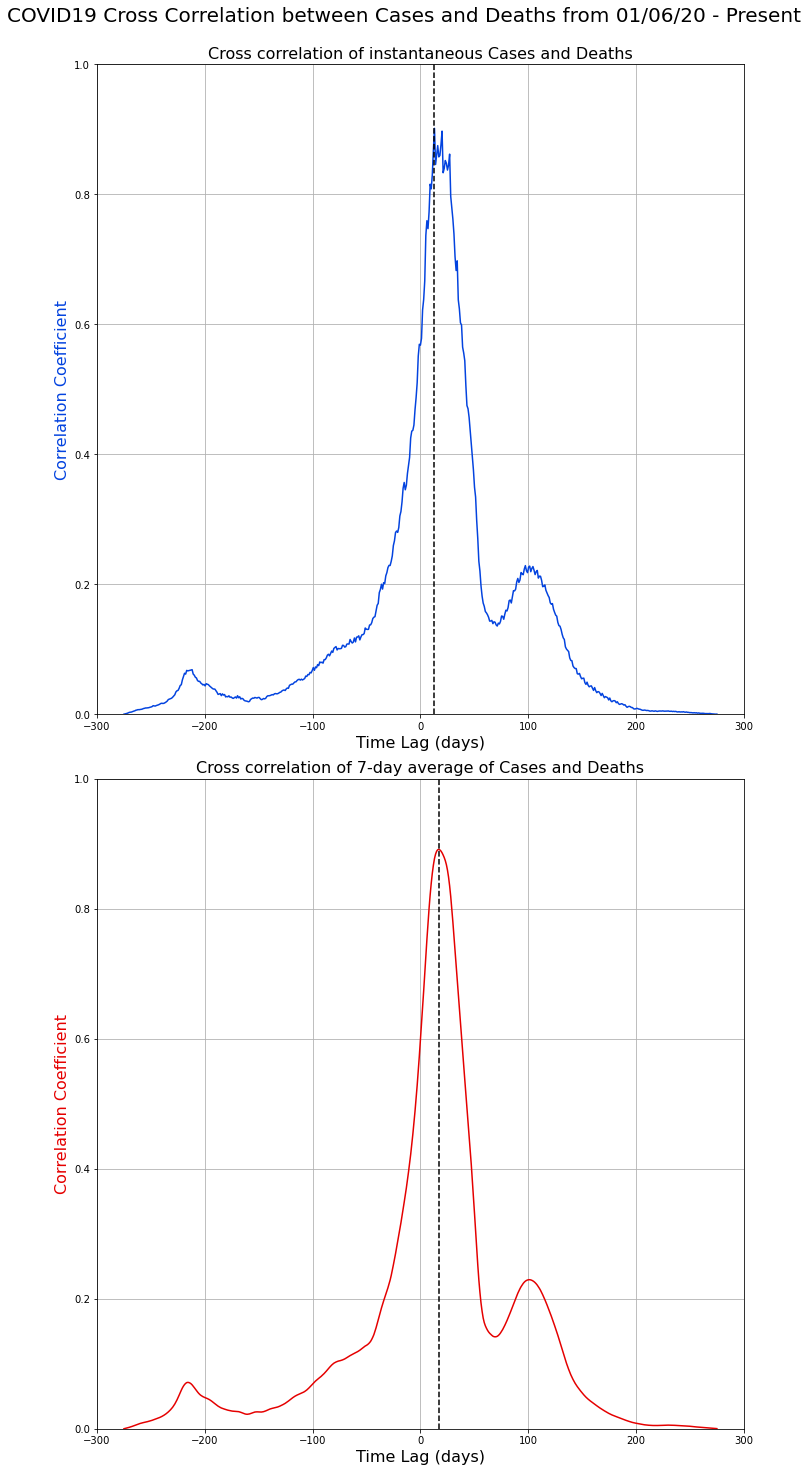

Instantaneous time lag between cases and deaths is 13.047445255474429 days.
Time lag between 7-day average of cases and deaths is 17.06204379562041 days.


In [53]:
fig, axis = plt.subplots(nrows = 2, ncols = 1, figsize=(10,20)) # Subplots to make 2 plots (nrows=2,ncols=1) with a figure size of 10x20.

# ============================================================
# Calculating time lag between instantaneous cases and deaths:
# ============================================================

num_days_inst = len(inst_cases_deaths_df.Cases) # Number of days to calculate the correlation over.
# Line below calculates the correlation coefficient between instantaneous cases and deaths:
corr = signal.correlate(inst_cases_deaths_df.Deaths, inst_cases_deaths_df.Cases, mode='full')/ np.sqrt(signal.correlate(inst_cases_deaths_df.Cases, inst_cases_deaths_df.Cases, mode='full')[int(num_days_inst)] * signal.correlate(inst_cases_deaths_df.Deaths, inst_cases_deaths_df.Deaths, mode='full')[int(num_days_inst)])
# delay_arr is an array of equally spaced points from -num_days_inst to num_days_inst. It is used to find the time lag between cases and deaths that maximises the correlation coefficient.
delay_arr = np.linspace(-num_days_inst, num_days_inst, len(corr))
time_lag = delay_arr[np.argmax(corr)] # argmax finds the index of the time lag (in days) that maximises the correlation coefficient. This is used to obtain the actual time lag using delay_arr.

# ============================================================
# Calculating time lag between 7-day average cases and deaths:
# ============================================================

num_days_ave7 = len(ave7_cases_deaths_df.Cases) # Number of days to calculate the correlation over.
# Line below calculates the correlation coefficient between 7-day average cases and deaths:
ave7_corr = signal.correlate(ave7_cases_deaths_df.Deaths, ave7_cases_deaths_df.Cases, mode='full')/ np.sqrt(signal.correlate(ave7_cases_deaths_df.Cases, ave7_cases_deaths_df.Cases, mode='full')[int(num_days_ave7)] * signal.correlate(ave7_cases_deaths_df.Deaths, ave7_cases_deaths_df.Deaths, mode='full')[int(num_days_ave7)])
# delay_arr is an array of equally spaced points from -num_days_ave7 to num_days_ave7. It is used to find the time lag between average cases and deaths that maximises the correlation coefficient.
ave7_delay_arr = np.linspace(-num_days_ave7, num_days_ave7, len(ave7_corr))
ave7_time_lag = ave7_delay_arr[np.argmax(ave7_corr)] # argmax finds the index of the time lag (in days) that maximises the correlation coefficient. This is used to obtain the actual time lag using delay_arr.

# ==============================================
# First plot for instantaneous cases and deaths:
# ==============================================

axis[0].plot(delay_arr,corr,color='xkcd:blue') # Plot correlation coefficient vs time lag.
axis[0].set_ylabel('Correlation Coefficient',color='xkcd:blue',fontsize=16) # Set label of y axis to 'Correlation Coefficient'.
axis[0].set_xlabel('Time Lag (days)',fontsize=16) # Set label of x axis to 'Time Lag (days)'.
axis[0].set_ylim([0, 1.0]) # Limit y axis scale to [0,1] (correlation coefficient can't go beyond this range).
axis[0].set_xlim([-300, 300]) # Limit x axis scale to [-300,300].
axis[0].grid() # Create gridlines on the plot.
axis[0].set_title('Cross correlation of instantaneous Cases and Deaths',fontsize=16) # Set subtitle of plot.
axis[0].axvline(time_lag,color='black',linestyle='dashed') # Plot a vertical line at the value of the time lag calculated by the correlation coefficient.

# ==================================================
# Second plot for 7-day average of cases and deaths:
# ==================================================

axis[1].plot(ave7_delay_arr,ave7_corr,color='xkcd:red') # Plot correlation coefficient for 7 day average vs time lag.
axis[1].set_ylabel('Correlation Coefficient',color='xkcd:red',fontsize=16) # Set label of y axis to 'Correlation Coefficient'.
axis[1].set_xlabel('Time Lag (days)',fontsize=16) # Set label of x axis to 'Time Lag (days)'.
axis[1].set_ylim([0, 1.0]) # Limit y axis scale to [0,1] (correlation coefficient can't go beyond this range).
axis[1].set_xlim([-300, 300]) # Limit x axis scale to [-300,300].
axis[1].grid() # Create gridlines on the plot.
axis[1].set_title('Cross correlation of 7-day average of Cases and Deaths',fontsize=16) # Set subtitle of plot.
axis[1].axvline(ave7_time_lag,color='black',linestyle='dashed') # Plot a vertical line at the value of the time lag calculated by the correlation coefficient.

fig.suptitle('COVID19 Cross Correlation between Cases and Deaths from 01/06/20 - Present',fontsize=20,y=1.02) # Create major title for plots, y=1.02 adds some padding between it and the minor titles.
fig.tight_layout()  # Remove excessive whitespace around plots.
plt.show()

print('Instantaneous time lag between cases and deaths is {} days.'.format(time_lag)) # Print instantaneous time lag.
print('Time lag between 7-day average of cases and deaths is {} days.'.format(ave7_time_lag)) # Print 7-day average time lag.

# 7. Rolling back the deaths to correlate with the number of cases:

### Instantaneous cases and deaths:

In [54]:
inst_df_shifted = inst_cases_deaths_df.copy() # Create a copy of instantaneous cases and deaths df before shifting deaths data.
inst_df_shifted.Deaths = inst_df_shifted.Deaths.shift(periods = -int(time_lag)) # Roll the Deaths column in inst_df_shifted back by time_lag number of days.
inst_df_shifted.dropna(axis=0,how='any',inplace=True) # Remove the NaNs that appear for the most recent days as a result of shifting the data backwards.
inst_df_shifted # Inspect the dataframe.

,Deaths,Cases
Date,,
2020/06/01,1.0,77
2020/06/02,0.0,10
2020/06/03,3.0,47
2020/06/04,3.0,38
2020/06/05,4.0,28
...,...,...
2021/02/13,29.0,1078
2021/02/14,13.0,788
2021/02/15,6.0,821


### 7-day average of cases and deaths:

In [55]:
ave7_df_shifted = ave7_cases_deaths_df.copy() # Create a copy of 7-day average cases and deaths df before shifting deaths data.
ave7_df_shifted.Deaths = ave7_df_shifted.Deaths.shift(periods = -int(ave7_time_lag)) # Roll the Deaths column in ave7_df_shifted back by ave7_time_lag number of days.
ave7_df_shifted.dropna(axis=0,how='any',inplace=True) # Remove the NaNs that appear for the most recent days as a result of shifting the data backwards.
ave7_df_shifted # Inspect the dataframe.

,Deaths,Cases
Date,,
2020/06/01,2.714286,77.000000
2020/06/02,2.571429,43.500000
2020/06/03,2.142857,44.666667
2020/06/04,2.000000,43.000000
2020/06/05,2.285714,40.000000
...,...,...
2021/02/09,27.571429,944.857143
2021/02/10,25.714286,943.857143
2021/02/11,26.428571,879.285714


## Plots of shifted cases and deaths:

Want to see how the shifted deaths and cases line up now.

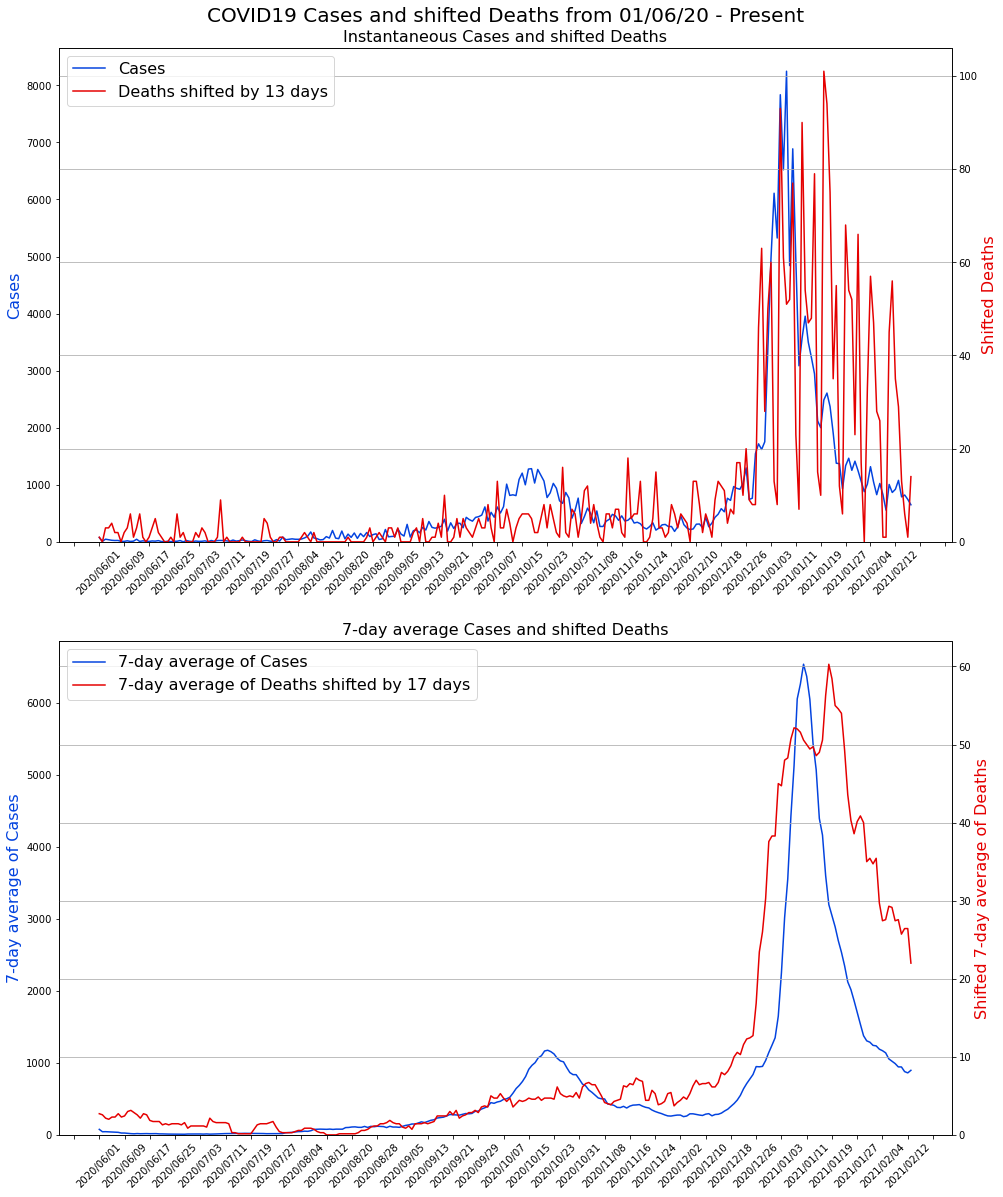

In [56]:
fig,ax = plt.subplots(nrows=2,ncols=1,figsize=(16,20)) # Subplots to make 2 plots (nrows=2,ncols=1) with a figure size of 16x20.

# ==============================================
# First plot for instantaneous cases and deaths:
# ==============================================

num_ticks_inst = len(inst_df_shifted.index)//7 # Calculate number of ticks to give a tick at approximately every 1 week interval on the x axis.
cases_trace = ax[0].plot(inst_df_shifted.Cases,color='xkcd:blue',label='Cases') # Plot Cases data. Dates are plot on the x axis as the dates are the index of the DF.
ax[0].set_ylabel('Cases',color='xkcd:blue',fontsize=16) # Set left hand yaxis label to 'Cases'.
ax[0].set_ylim(bottom=0) # Limit the y axis ('Cases') to start at 0.
ax[0].xaxis.set_major_locator(plt.MaxNLocator(num_ticks_inst)) # Set the number of ticks on the x axis to num_ticks_inst (ticks @ approx. 1 week intervals).
labels = ax[0].get_xticklabels() # Return tick labels (Dates) as an object so that they can be rotated.
ax[0].set_xticklabels(labels,rotation=45) # Rotate x axis labels @ 45 degrees.
ax[0].set_title('Instantaneous Cases and shifted Deaths',fontsize=16) # Sub-title for 1st plot for the instantaneous cases and deaths.

ax2 = ax[0].twinx() # Create a second y axis on the right hand side of the plot using the same x axis.
deaths_trace = ax2.plot(inst_df_shifted.Deaths,color='xkcd:red',label='Deaths shifted by {:.0f} days'.format(time_lag)) # Plot shifted Deaths data, dates on x axis.
ax2.set_ylabel('Shifted Deaths',color='xkcd:red',fontsize=16) # Set right hand yaxis label to 'Shifted Deaths'.
ax2.set_ylim(bottom=0) # Limit the right-hand y axis ('Shifted Deaths') to start at 0.
ax2.grid() # Plot gridlines for the right hand y axis.
ax2.legend(cases_trace + deaths_trace, ['Cases','Deaths shifted by {:.0f} days'.format(time_lag)], fontsize=16, loc='best') # Create legend for Cases and Deaths traces in the best location as determined by matplotlib.
xticks = ax2.xaxis.set_major_locator(plt.MaxNLocator(num_ticks_inst)) # Limit number of ticks on x axis to num_ticks_inst (~1 week intervals).

plt.title('COVID19 Cases and shifted Deaths from 01/06/20 - Present',fontsize=20,y=1.04) # Set major title for both plots. y=1.04 positions the title so that it doesn't overlap with the minor titles.

# ==================================================
# Second plot for 7-day average of cases and deaths:
# ==================================================

num_ticks_ave7 = len(ave7_df_shifted.index)//7 # Calculate number of ticks to give a tick at approximately every 1 week interval on the x axis.
ave7_cases_trace = ax[1].plot(ave7_df_shifted.Cases,color='xkcd:blue') # Plot 7-day average Cases data. Dates are plot on the x axis as the dates are the index of the DF.
ax[1].set_ylabel('7-day average of Cases',color='xkcd:blue',fontsize=16) # Set left hand yaxis label to '7-day average of Cases'.
ax[1].set_ylim(bottom=0) # Limit the left-hand y axis ('7-day average of Cases') to start at 0.
ax[1].xaxis.set_major_locator(plt.MaxNLocator(num_ticks_ave7)) # Set the number of ticks on the x axis to num_ticks_ave7 (ticks @ approx. 1 week intervals). 
labels = ax[1].get_xticklabels() # Return tick labels (Dates) as an object so that they can be rotated.
ax[1].set_xticklabels(labels,rotation=45) # Rotate x axis labels @ 45 degrees.
ax[1].set_title('7-day average Cases and shifted Deaths',fontsize=16) # Sub-title for 2nd plot for the 7-day average of cases and deaths.

ax2 = ax[1].twinx() # Create a second y axis on the right hand side of the plot using the same x axis.
ave7_deaths_trace = ax2.plot(ave7_df_shifted.Deaths,color='xkcd:red') # Plot shifted 7-day average of Deaths data, dates on x axis.
ax2.set_ylabel('Shifted 7-day average of Deaths',color='xkcd:red',fontsize=16) # Set right hand yaxis label to 'Shifted 7-day average of Deaths'.
ax2.set_ylim(bottom=0) # Limit the right-hand y axis ('Shifted 7-day average of Deaths') to start at 0.
ax2.grid() # Plot a grid for the right hand y axis.
ax2.legend(ave7_cases_trace + ave7_deaths_trace, ['7-day average of Cases','7-day average of Deaths shifted by {:.0f} days'.format(ave7_time_lag)], fontsize=16, loc='best') # Create legend for average Cases and Deaths traces in the best location as determined by matplotlib.
xticks = ax2.xaxis.set_major_locator(plt.MaxNLocator(num_ticks_ave7)) # Limit number of ticks on x axis to num_ticks_ave7 (~1 week intervals).

plt.show()

## Scatter plot of cases and shifted deaths data:

Colourmap indicates the number of days since 1st June for each instance - i.e. colour is darker for the most recent dates. This was done to see if there was any clear pattern present between cases and deaths in the third wave due to the UK variant.

Text(0.5, 1.0, 'Scatter plot of 7-day average Cases vs shifted Deaths')

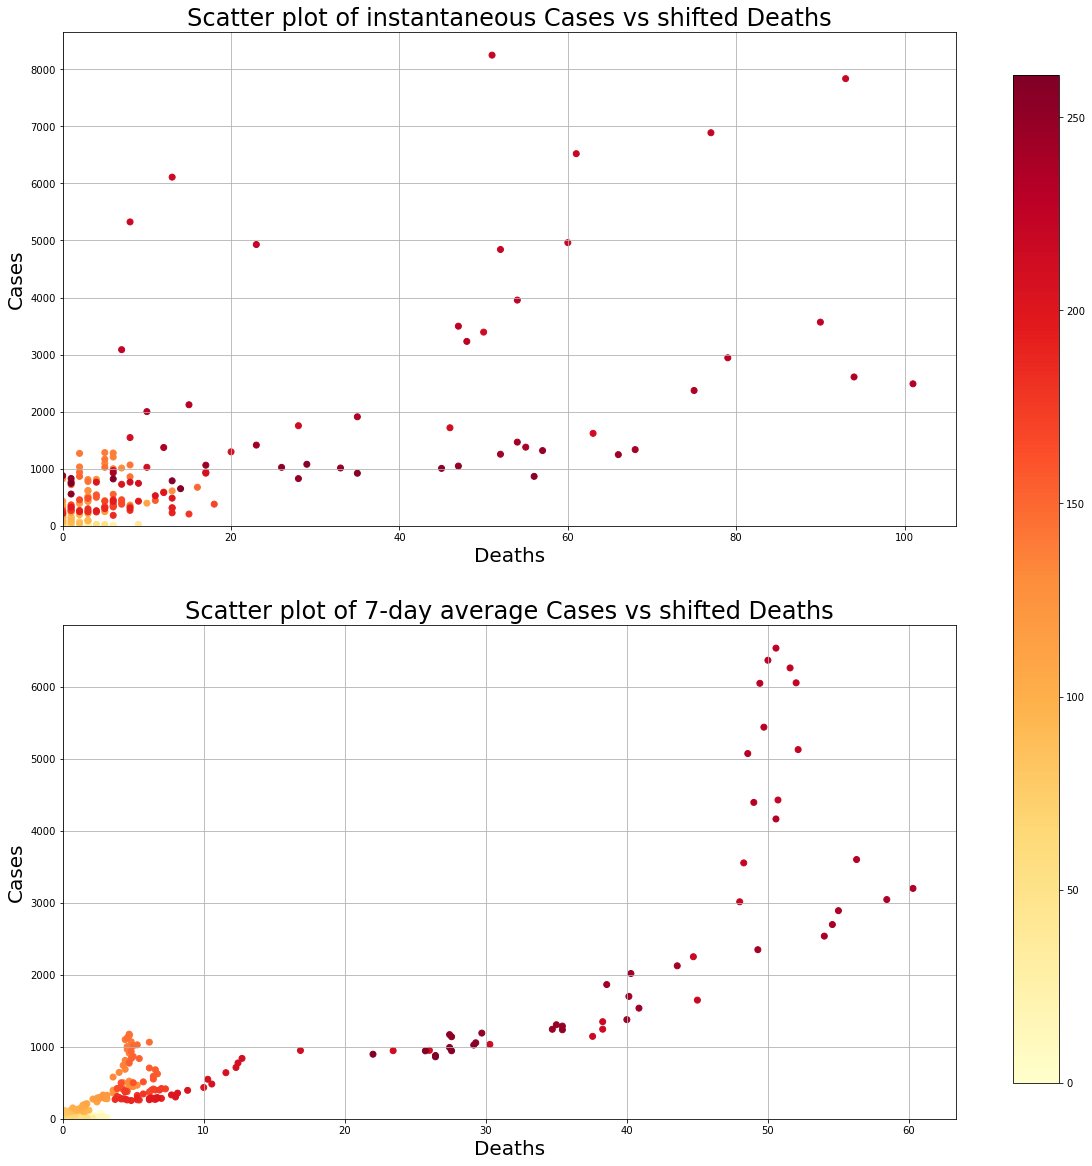

In [57]:
fig,ax = plt.subplots(nrows=2,ncols=1,figsize=(16,20)) # Subplots to make 2 plots (nrows=2,ncols=1) with a figure size of 16x20.

# ======================================================
# First scatter plot for instantaneous cases and deaths:
# ======================================================

scatter = ax[0].scatter(inst_df_shifted.Deaths.values,
                        inst_df_shifted.Cases.values,
                        c=np.arange(len(inst_df_shifted.Deaths)),cmap='YlOrRd') # Creates a scatter plot of cases vs shifted deaths, with each instance assigned a colour according to the days since 01/06/20 for that instance.
cbar_ax = fig.add_axes([0.95, 0.15, 0.04, 0.7]) # Colour bar for colourmap requires its own axis. This specifies the dimensions & position of this axis.
fig.colorbar(scatter, cax=cbar_ax, orientation='vertical') # Creates the vertical colour bar on the new colourbar axis cax.
ax[0].set_xlabel('Deaths',fontsize=20) # Sets the label of the x axis to 'Deaths'
ax[0].set_ylabel('Cases',fontsize=20) # Sets the label of the y axis to 'Cases'
ax[0].set_ylim(bottom=0) # Limit the y axis ('Cases') to start at 0.
ax[0].set_xlim(left=0) # Limit the x axis ('Deaths') to start at 0.
ax[0].grid() # Plot gridlines.
ax[0].set_title('Scatter plot of instantaneous Cases vs shifted Deaths',fontsize=24) # Set subtitle of scatter plot.

# ==========================================================
# Second scatter plot for 7-day average of cases and deaths:
# ==========================================================

scatter = ax[1].scatter(ave7_df_shifted.Deaths.values,
                        ave7_df_shifted.Cases.values,
                        c=np.arange(len(ave7_df_shifted.Cases)),cmap='YlOrRd') # Creates a scatter plot of 7-day average cases vs shifted deaths, with each instance assigned a colour according to the days since 01/06/20 for that instance.
ax[1].set_xlabel('Deaths',fontsize=20) # Sets the label of the x axis to 'Deaths'
ax[1].set_ylabel('Cases',fontsize=20) # Sets the label of the y axis to 'Cases'
ax[1].set_ylim(bottom=0) # Limit the y axis ('Cases') to start at 0.
ax[1].set_xlim(left=0) # Limit the x axis ('Deaths') to start at 0.
ax[1].grid() # Plot gridlines.
ax[1].set_title('Scatter plot of 7-day average Cases vs shifted Deaths',fontsize=24) # Set subtitle of scatter plot.

# 8. Correlation Coefficients

Pearson's correlation coefficient measures the strength of the linear relationship between two variables, while Spearman's correlation coefficient measures the strength of the monotonic relationship between two variables.

### Instantaneous cases and deaths

In [58]:
spearmanr(inst_df_shifted.Deaths.values,inst_df_shifted.Cases.values) # Spearman's Correlation Coefficient

SpearmanrResult(correlation=0.7197430851919587, pvalue=4.245389480417607e-43)

In [59]:
pearsonr(inst_df_shifted.Deaths.values,inst_df_shifted.Cases.values) # Pearson's Correlation Coefficient

(0.6973713320962845, 1.7303693522930732e-39)

### 7-day average cases and deaths

In [60]:
spearmanr(ave7_df_shifted.Deaths.values,ave7_df_shifted.Cases.values) # Spearman's Correlation Coefficient

SpearmanrResult(correlation=0.8553065537486172, pvalue=4.563726890269757e-75)

In [61]:
pearsonr(ave7_df_shifted.Deaths.values,ave7_df_shifted.Cases.values) # Pearson's Correlation Coefficient

(0.858974482260632, 2.1873808905958813e-76)

# 9. Create a training set from the shifted data from 01/06/20

Initial approach used a training and validation set created using train_test_split. However, there was considerable variation in results depending on the test set used - if the random seed was changed, the RMSE could jump from as low as 530 to well over 700. As a result, I replaced the training/validation set with cross-validation, using 5 cross-validation folds.

In cross-validation, the dataset is split into k folds. The model is trained on k-1 folds and tested on the remaining fold. This process is repeated until all k folds have been used as a test fold. This gives a more robust estimate of the model performance. cross_val_score expects a utility function (greater is better), so neg_mean_squared_error is used as the scoring metric.

The data has to be shuffled before doing cross validation - or else it will break it into 5 sequential chunks, and the last chunk (corresponding to most of the third wave) was completely skewing the RMSE. A random permutation of the index allows the cases and deaths data to be shuffled the same way.

train_test_split documentation: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

cross_val_score documentation: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html

In [62]:
np.random.seed(0) # Set seed of RNG for reproducability.
shuffled_inst_index = np.random.permutation(len(inst_df_shifted)) # Shuffle data before creating training set.
Deaths_train = inst_df_shifted.Deaths.values.reshape((-1,1))[shuffled_inst_index] # Create training data for instantaneous deaths.
Cases_train = inst_df_shifted.Cases.values[shuffled_inst_index] # Create training labels for instantaneous cases.

In [63]:
np.random.seed(0) # Set seed of RNG for reproducability.
shuffled_ave7_index = np.random.permutation(len(ave7_df_shifted)) # Shuffle data before creating training set.
ave7_Deaths_train = ave7_df_shifted.Deaths.values.reshape((-1,1))[shuffled_ave7_index] # Create training data for 7-day average deaths.
ave7_Cases_train = ave7_df_shifted.Cases.values[shuffled_ave7_index] # Create training labels for 7-day average cases.

# 10. Linear Regression

### Instantaneous cases and deaths

In [64]:
LR_inst = LinearRegression() # Instantiate sklearn's linear regression model.
LR_scores = cross_val_score(LR_inst, Deaths_train, Cases_train, 
                            scoring='neg_mean_squared_error',cv=5,n_jobs=-1) # Run cross validation on training set using a linear regression model, with 5 folds and the neg_mean_squared_error utility function.
inst_LR_rmse = np.sqrt(-LR_scores) # Calculate the root mean squared error between the actual case numbers and the predicted case numbers across the 5 cross-validation folds.
print('Mean and Standard Deviation of root mean squared error of instantaneous cases across 5 CV folds using Linear Regression:\nMean: {}\nStd: {}'.format(np.mean(inst_LR_rmse),np.std(inst_LR_rmse)))
LR_inst.fit(Deaths_train, Cases_train) # Fit LR model to whole training set (to later make predictions from 29/02/20-31/05/20)

Mean and Standard Deviation of root mean squared error of instantaneous cases across 5 CV folds using Linear Regression:
Mean: 932.2785788432013
Std: 111.16594314733797


LinearRegression()

### 7-day average cases and deaths

In [65]:
LR_ave = LinearRegression() # Instantiate sklearn's linear regression model.
LR_scores = cross_val_score(LR_ave, ave7_Deaths_train, ave7_Cases_train, 
                            scoring='neg_mean_squared_error',cv=5,n_jobs=-1) # Run cross validation on training set using a linear regression model, with 5 folds and the neg_mean_squared_error utility function.
ave7_LR_rmse = np.sqrt(-LR_scores) # Calculate the root mean squared error between the 7-day average case numbers and the predicted case numbers across the 5 cross-validation folds.
print('Mean and Standard Deviation of root mean squared error across 5 CV folds for 7-day average cases using Linear Regression:\nMean: {}\nStd: {}'.format(np.mean(ave7_LR_rmse),np.std(ave7_LR_rmse)))
LR_ave.fit(ave7_Deaths_train, ave7_Cases_train) # Fit LR model to whole training set (to later make predictions from 29/02/20-31/05/20).

Mean and Standard Deviation of root mean squared error across 5 CV folds for 7-day average cases using Linear Regression:
Mean: 614.9154345164392
Std: 168.66260264479104


LinearRegression()

## Plotting the Linear Regression models:

Visualise how well the linear model fits the data.

Text(0.5, 1.0, 'Scatter plot of 7-day average Cases vs Deaths')

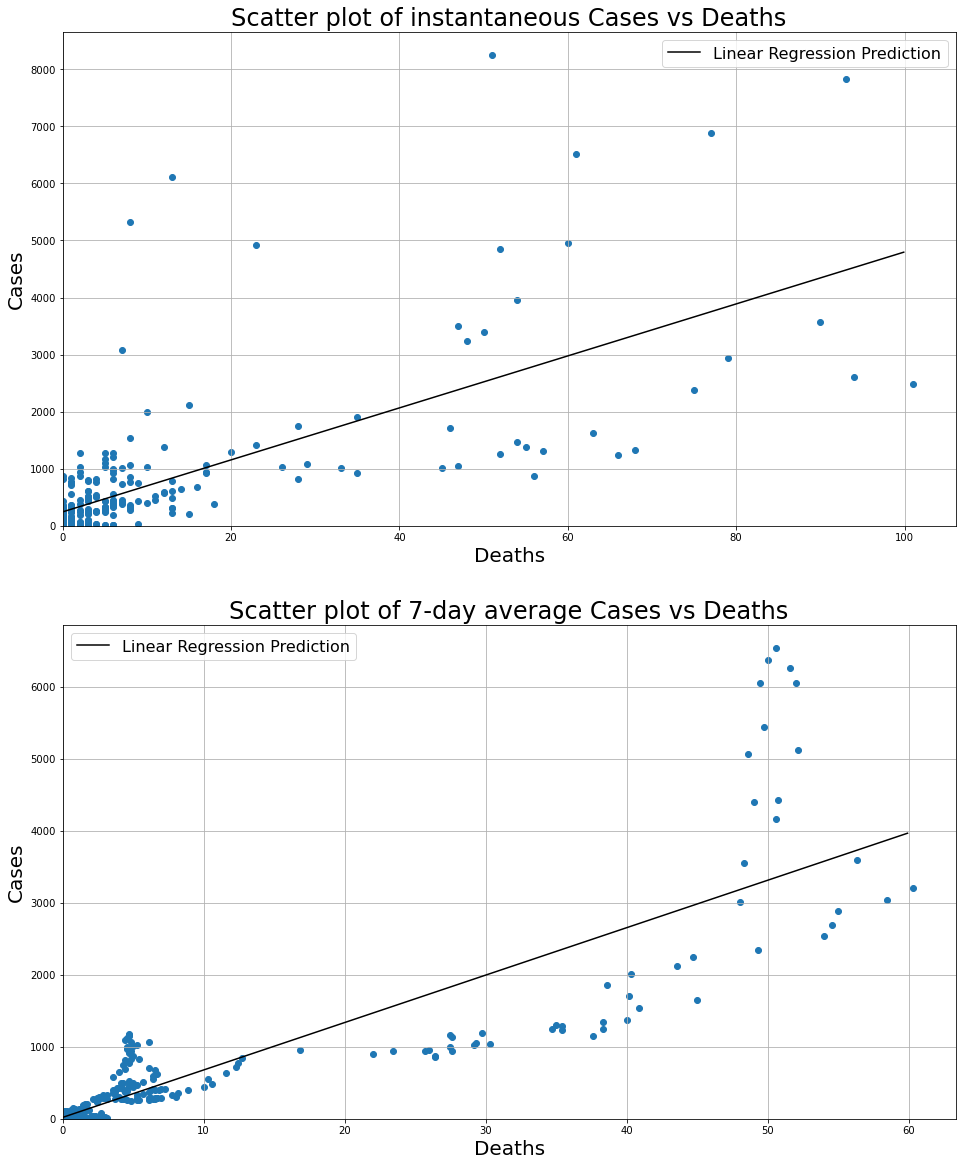

In [66]:
fig,ax = plt.subplots(nrows=2,ncols=1,figsize=(16,20)) # Subplots to make 2 plots (nrows=2,ncols=1) with a figure size of 16x20.

# ======================================================
# First scatter plot for instantaneous cases and deaths:
# ======================================================

scatter = ax[0].scatter(inst_df_shifted.Deaths.values,
                        inst_df_shifted.Cases.values) # Creates a scatter plot of cases vs shifted deaths.
LR = ax[0].plot(np.arange(0,100,0.1),
                LR_inst.predict(np.arange(0,100,0.1).reshape(-1,1)),color='black') # Plot linear regression model for instantaneous cases and deaths.
ax[0].legend(LR,['Linear Regression Prediction'],loc='best',fontsize=16) # Creates legend for linear regression model.
ax[0].set_xlabel('Deaths',fontsize=20) # Sets the label of the x axis to 'Deaths'
ax[0].set_ylabel('Cases',fontsize=20) # Sets the label of the y axis to 'Cases'
ax[0].set_ylim(bottom=0) # Limit the y axis ('Cases') to start at 0.
ax[0].set_xlim(left=0) # Limit the x axis ('Deaths') to start at 0.
ax[0].grid() # Plot gridlines.
ax[0].set_title('Scatter plot of instantaneous Cases vs Deaths',fontsize=24) # Set subtitle of scatter plot.

# ==========================================================
# Second scatter plot for 7-day average of cases and deaths:
# ==========================================================

scatter = ax[1].scatter(ave7_df_shifted.Deaths.values,
                        ave7_df_shifted.Cases.values) # Creates a scatter plot of 7-day average cases vs shifted deaths.
LR = ax[1].plot(np.arange(0,60,0.1),
                LR_ave.predict(np.arange(0,60,0.1).reshape(-1,1)),
                color='black',label='Linear Regression Prediction') # Plot linear regression model for 7-day average cases and deaths.
ax[1].legend(LR,['Linear Regression Prediction'],loc='best',fontsize=16) # Creates legend for linear regression model.
ax[1].set_xlabel('Deaths',fontsize=20) # Sets the label of the x axis to 'Deaths'
ax[1].set_ylabel('Cases',fontsize=20) # Sets the label of the y axis to 'Cases'
ax[1].set_ylim(bottom=0) # Limit the y axis ('Cases') to start at 0.
ax[1].set_xlim(left=0) # Limit the x axis ('Deaths') to start at 0.
ax[1].grid() # Plot gridlines.
ax[1].set_title('Scatter plot of 7-day average Cases vs Deaths',fontsize=24) # Set subtitle of scatter plot.

# 11. Polynomial Regression & Gridsearch for 7-day average data:

The 7-day average of cases and deaths looks like it has a quadratic or almost cubic profile. We can do a gridsearch + cross validation to determine the degree of the polynomial regressor that will yield the best performance.

Scikit-learn's Pipeline object acts like a data pipeline, allowing you to sequentially apply transformations to the data that is passed. All but the last estimator must be transformers. In this case, PolynomialFeatures is the only transformer and a LinearRegression model is used as the final estimator. The Pipeline object exposes the methods of the final estimator in the pipeline - in this case, fit and predict.

Scikit-learn's GridSearchCV performs allows you to test various hyperparameters using k-fold cross validation. Using it here with 5 folds to determine the degree of the polynomial regression model that yields the best performance. Scikit-learn's cross-validation functions require a utility scoring function (greater is better) rather than a cost function, so neg_mean_squared_error is used instead of mean_squared_error.

Documentation for PolynomialFeatures transformer: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html

Documentation for Pipeline: https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

Documentation for GridSearchCV: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [67]:
poly_regression_pipeline = Pipeline([('poly_transformer',PolynomialFeatures(degree = 1, include_bias=False)),
                                    ('reg_model',LinearRegression())]) # Construct sklearn Pipeline of PolynomialFeatures transformer and LinearRegression estimator.

param_grid = {'poly_transformer__degree':[2,3]} # The order/degree of the polynomial regression model that we want to cross validate.

grid_search = GridSearchCV(poly_regression_pipeline,
                           param_grid,scoring='neg_mean_squared_error',
                           cv=5,verbose=3,refit=True) # Instantiate the grid search object using negative mean squared error scoring & 5 folds for cross validation. refit=True fits the model to the whole training set once gridsearch is complete.
grid_search.fit(ave7_Deaths_train,ave7_Cases_train) # Run the gridsearch on the training set.

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] poly_transformer__degree=2 ......................................
[CV] .... poly_transformer__degree=2, score=-744330.549, total=   0.0s
[CV] poly_transformer__degree=2 ......................................
[CV] .... poly_transformer__degree=2, score=-104814.071, total=   0.0s
[CV] poly_transformer__degree=2 ......................................
[CV] .... poly_transformer__degree=2, score=-266461.481, total=   0.0s
[CV] poly_transformer__degree=2 ......................................
[CV] .... poly_transformer__degree=2, score=-348087.518, total=   0.0s
[CV] poly_transformer__degree=2 ......................................
[CV] .... poly_transformer__degree=2, score=-259258.169, total=   0.0s
[CV] poly_transformer__degree=3 ......................................
[CV] .... poly_transformer__degree=3, score=-835275.008, total=   0.0s
[CV] poly_transformer__degree=3 ......................................
[CV] ..... poly_t

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('poly_transformer',
                                        PolynomialFeatures(degree=1,
                                                           include_bias=False)),
                                       ('reg_model', LinearRegression())]),
             param_grid={'poly_transformer__degree': [2, 3]},
             scoring='neg_mean_squared_error', verbose=3)

In [68]:
grid_search.cv_results_ # Print cross_validation results.

{'mean_fit_time': array([0.00139875, 0.00099883]),
 'std_fit_time': array([4.89239651e-04, 1.16800773e-07]),
 'mean_score_time': array([0.00059915, 0.00019975]),
 'std_score_time': array([0.0004892 , 0.00039949]),
 'param_poly_transformer__degree': masked_array(data=[2, 3],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'poly_transformer__degree': 2}, {'poly_transformer__degree': 3}],
 'split0_test_score': array([-744330.54871088, -835275.00774884]),
 'split1_test_score': array([-104814.07081528,  -92523.83495932]),
 'split2_test_score': array([-266461.48123187, -261307.46788945]),
 'split3_test_score': array([-348087.51792633, -341659.86261051]),
 'split4_test_score': array([-259258.16937076, -245897.21635782]),
 'mean_test_score': array([-344590.35761102, -355332.67791319]),
 'std_test_score': array([214794.23730376, 253146.96685798]),
 'rank_test_score': array([1, 2])}

In [69]:
grid_search.best_params_ # Inspect the best hyperparameters determined by gridsearch.

{'poly_transformer__degree': 2}

Can't access the neg_mean_squared_error scores for each of the 5 CV folds without hard coding a lot of the indexes/dictionary addresses. 

GridSearchCV.best_score_ attribute returns the mean of the neg_mean_squared_error scores across the 5 CV folds - the square root of this is different to taking the square root of the neg_mean_squared_error scores across the 5 CV folds individually and then taking the mean.

As a result, I use cross_val_score again to conveniently calculate the RMSE of the best polynomial regression model as determined by the grid search.

In [70]:
best_poly_reg = grid_search.best_estimator_ # Assign the best performing model to best_poly_reg (best performing model is trained on whole training set as refit=True).
PR_scores = cross_val_score(best_poly_reg, ave7_Deaths_train, ave7_Cases_train, 
                            scoring='neg_mean_squared_error',cv=5,n_jobs=-1) # Run cross validation on training set using a Polynomial regression model, with 5 folds and the neg_mean_squared_error utility function.
ave7_PR_rmse = np.sqrt(-PR_scores) # Calculate the root mean squared error between the 7-day average case numbers and the predicted case numbers across the 5 cross-validation folds.
print('Mean and Standard Deviation of root mean squared error across 5 CV folds for 7-day average cases using Polynomial Regression:\nMean: {}\nStd: {}'.format(np.mean(ave7_PR_rmse),np.std(ave7_PR_rmse)))
best_poly_reg.fit(ave7_Deaths_train, ave7_Cases_train) # Fit PR model to whole training set (to later make predictions from 29/02/20-31/05/20).

Mean and Standard Deviation of root mean squared error across 5 CV folds for 7-day average cases using Polynomial Regression:
Mean: 560.3716896419689
Std: 174.85401642178115


Pipeline(steps=[('poly_transformer', PolynomialFeatures(include_bias=False)),
                ('reg_model', LinearRegression())])

## Plot Polynomial Regression model on 7-day average scatter plot:

Text(0.5, 1.0, 'Scatter plot of 7-day average Cases vs Deaths')

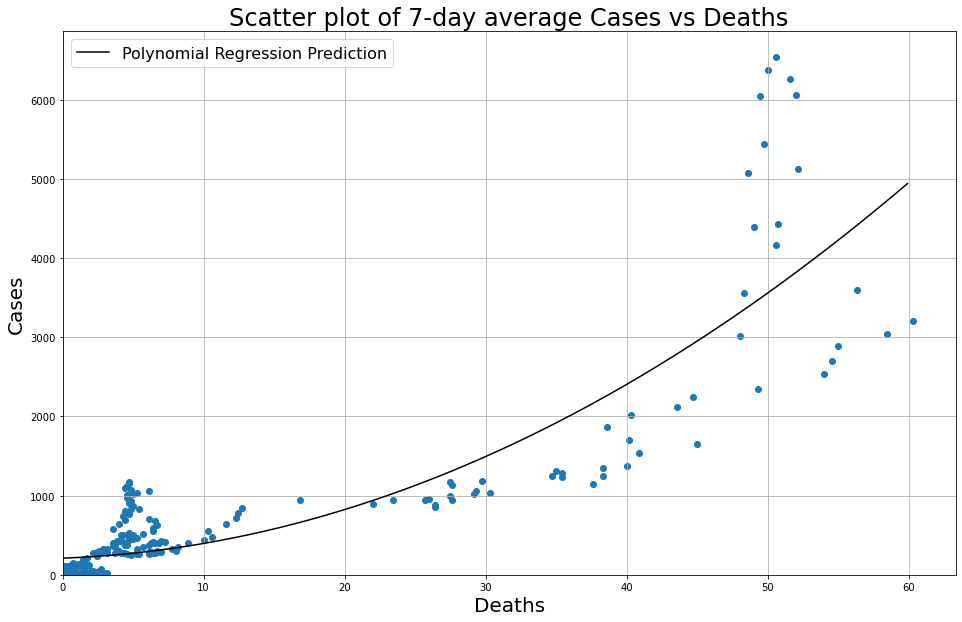

In [71]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(16,10)) # Subplots to make 1 plot (nrows=1,ncols=1) with a figure size of 16x10.

scatter = ax.scatter(ave7_df_shifted.Deaths.values,
                     ave7_df_shifted.Cases.values) # Creates a scatter plot of 7-day average cases vs shifted deaths.

PR = ax.plot(np.arange(0,60,0.1),
            best_poly_reg.predict(np.arange(0,60,0.1).reshape((-1,1))),
             color='black',label='Linear Regression Prediction') # Plot polynomial regression model for 7-day average cases and deaths.

ax.legend(PR,['Polynomial Regression Prediction'],loc='best',fontsize=16) # Creates legend for polynomial regression model.
ax.set_xlabel('Deaths',fontsize=20) # Sets the label of the x axis to 'Deaths'
ax.set_ylabel('Cases',fontsize=20) # Sets the label of the y axis to 'Cases'
ax.set_ylim(bottom=0) # Limit the y axis ('Cases') to start at 0.
ax.set_xlim(left=0) # Limit the x axis ('Deaths') to start at 0.
ax.grid() # Plot gridlines.
ax.set_title('Scatter plot of 7-day average Cases vs Deaths',fontsize=24) # Set plot title.

# 12. Support Vector Machine

Support Vector Machine seeks to fit as many training instances as possible on its margin or street when used for regression.

Trying a Linear and Gaussian kernel SVM to see if the RMSE for the 7-day average cases and deaths can be improved. I'm also going to see if it improves the results for instantaneous cases and deaths.

SVMs require the features to be scaled (although with only 1 feature it may not be needed). Using sklearn's StandardScaler() transformer to standardise (subtract mean and divide by std) the Deaths data.

Documentation for Support Vector Regression model: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html

Documentation for StandardScaler transformer: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

### Instantaneous cases and deaths

In [72]:
inst_std_scaler = StandardScaler() # Instantiate standard scaler for instantaneous cases and deaths data. 
deaths_train_scaled = inst_std_scaler.fit_transform(Deaths_train) # fit_transform method fits the scaler to the training set 
                                                                  # (i.e. calculates the mean and std of the training set) and scales the training set.

In [73]:
inst_svm_params = {'kernel':['linear','rbf'],'C':[0.001,0.01,0.1,1,10,50],
                   'gamma':[0.001,0.01,0.1,1,10,100,1000],'epsilon':[0.001,0.01,0.1,1,10,100]} # SVM hyperparameters to test during the gridsearch. Gamma ignored when testing linear kernel.
inst_svm = SVR() # Instantiate SVM for regression.
inst_svm_GS = GridSearchCV(inst_svm,inst_svm_params,scoring='neg_mean_squared_error',
                           cv=5,verbose=3,refit=True,n_jobs=-1) # Instantiate gridsearch object for SVM. Parameters of gridsearch kept the same as those for poly regression.
inst_svm_GS.fit(deaths_train_scaled,Cases_train) # Run the gridsearch on the training set.

Fitting 5 folds for each of 504 candidates, totalling 2520 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 2520 out of 2520 | elapsed:    1.6s finished


GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 50],
                         'epsilon': [0.001, 0.01, 0.1, 1, 10, 100],
                         'gamma': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'kernel': ['linear', 'rbf']},
             scoring='neg_mean_squared_error', verbose=3)

In [74]:
inst_svm_GS.best_params_ # Inspect best SVM hyperparameters found by gridsearch.

{'C': 50, 'epsilon': 1, 'gamma': 0.001, 'kernel': 'linear'}

In [75]:
best_inst_svm  = inst_svm_GS.best_estimator_ # Assign the best performing model to best_inst_svm (best performing model is trained on whole training set as refit=True).
SVM_scores = cross_val_score(best_inst_svm, deaths_train_scaled,Cases_train, 
                            scoring='neg_mean_squared_error',cv=5,n_jobs=-1) # Run cross validation on training set using SVM model, with 5 folds and the neg_mean_squared_error utility function.
inst_svm_rmse = np.sqrt(-SVM_scores) # Calculate the root mean squared error between the 7-day average case numbers and the predicted case numbers across the 5 cross-validation folds.
print('Mean and Standard Deviation of root mean squared error across 5 CV folds for instantaneous cases using SVM:\nMean: {}\nStd: {}'.format(np.mean(inst_svm_rmse),np.std(inst_svm_rmse)))
best_inst_svm.fit(deaths_train_scaled,Cases_train) # Fit SVM model to whole training set (to later make predictions from 29/02/20-31/05/20).

Mean and Standard Deviation of root mean squared error across 5 CV folds for instantaneous cases using SVM:
Mean: 976.3210214784322
Std: 195.2938633587899


SVR(C=50, epsilon=1, gamma=0.001, kernel='linear')

### 7-day average cases and deaths

In [76]:
ave7_std_scaler = StandardScaler() # Instantiate standard scaler for 7-day average cases and deaths data. 
ave7_deaths_train_scaled = ave7_std_scaler.fit_transform(ave7_Deaths_train) # fit_transform method fits the scaler to the training set 
                                                                  # (i.e. calculates the mean and std of the training set) and scales the training set.

In [77]:
ave7_svm_params = {'kernel':['linear','rbf'],'C':[0.001,0.01,0.1,1,10,50],
                   'gamma':[0.001,0.01,0.1,1,10,100,1000],'epsilon':[0.001,0.01,0.1,1,10,100]} # SVM hyperparameters to test during the gridsearch. Gamma ignored when testing linear kernel.
ave7_svm = SVR() # Instantiate SVM for regression.
ave7_svm_GS = GridSearchCV(ave7_svm,ave7_svm_params,scoring='neg_mean_squared_error',
                           cv=5,verbose=3,refit=True,n_jobs=-1)  # Instantiate gridsearch object for SVM. Parameters of gridsearch kept the same as those for poly regression.
ave7_svm_GS.fit(ave7_deaths_train_scaled,ave7_Cases_train) # Run the gridsearch on the training set.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    0.0s


Fitting 5 folds for each of 504 candidates, totalling 2520 fits


[Parallel(n_jobs=-1)]: Done 2520 out of 2520 | elapsed:    1.5s finished


GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 50],
                         'epsilon': [0.001, 0.01, 0.1, 1, 10, 100],
                         'gamma': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'kernel': ['linear', 'rbf']},
             scoring='neg_mean_squared_error', verbose=3)

In [78]:
ave7_svm_GS.best_params_ # Inspect best SVM hyperparameters found by gridsearch.

{'C': 50, 'epsilon': 100, 'gamma': 0.001, 'kernel': 'linear'}

In [79]:
best_ave7_svm  = ave7_svm_GS.best_estimator_ # Assign the best performing model to best_ave7_svm (best performing model is trained on whole training set as refit=True).
SVM_scores = cross_val_score(best_ave7_svm, ave7_deaths_train_scaled,ave7_Cases_train, 
                            scoring='neg_mean_squared_error',cv=5,n_jobs=-1) # Run cross validation on training set using a Polynomial regression model, with 5 folds and the neg_mean_squared_error utility function.
ave7_svm_rmse = np.sqrt(-SVM_scores) # Calculate the root mean squared error between the 7-day average case numbers and the predicted case numbers across the 5 cross-validation folds.
print('Mean and Standard Deviation of root mean squared error across 5 CV folds for 7-day average cases using SVM:\nMean: {}\nStd: {}'.format(np.mean(ave7_svm_rmse),np.std(ave7_svm_rmse)))
best_ave7_svm.fit(ave7_deaths_train_scaled,ave7_Cases_train) # Fit SVM model to whole training set (to later make predictions from 29/02/20-31/05/20).

Mean and Standard Deviation of root mean squared error across 5 CV folds for 7-day average cases using SVM:
Mean: 672.0249729617166
Std: 240.3307764468234


SVR(C=50, epsilon=100, gamma=0.001, kernel='linear')

## Plot best Support Vector Machine models on respective scatter plots:

Text(0.5, 1.0, 'Scatter plot of 7-day average Cases vs Deaths')

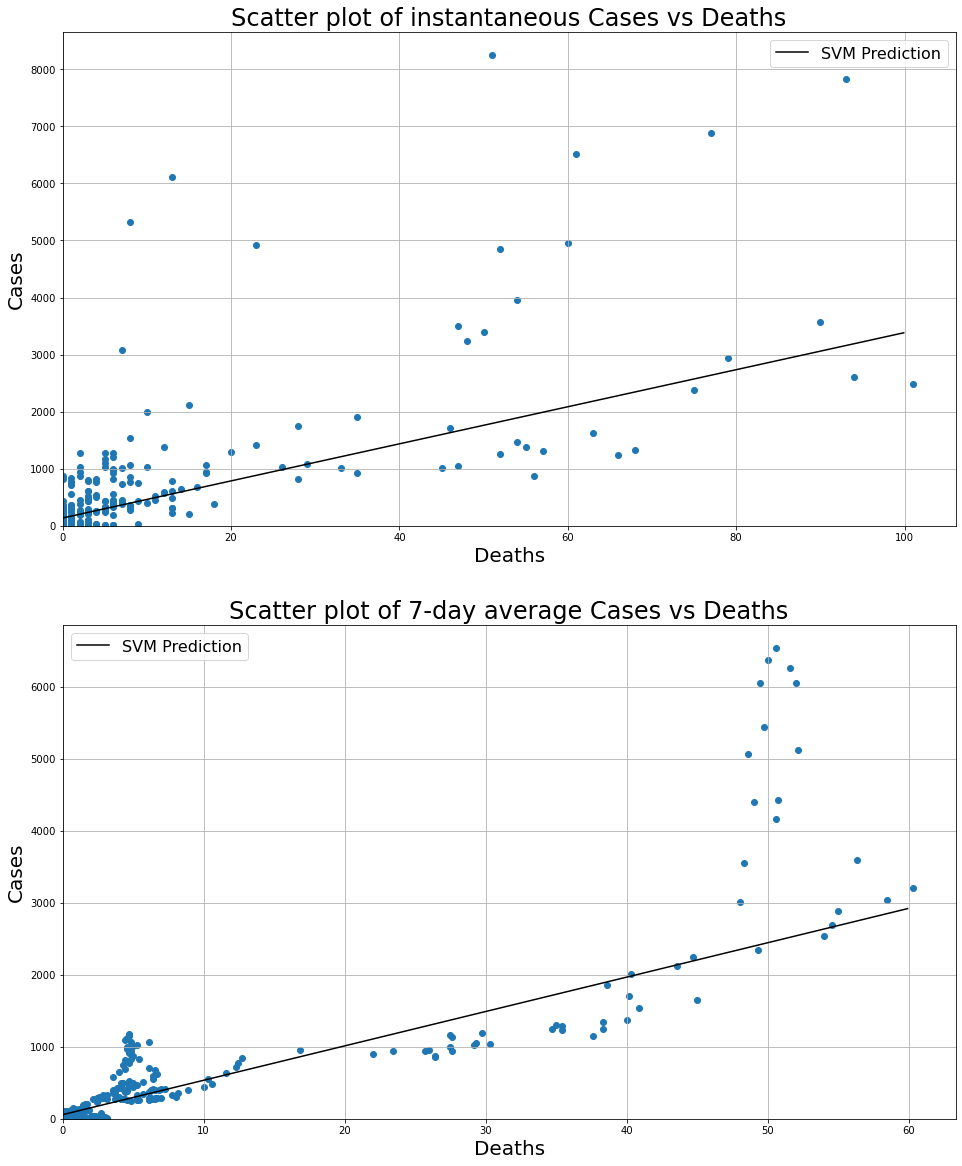

In [80]:
fig,ax = plt.subplots(nrows=2,ncols=1,figsize=(16,20)) # Subplots to make 2 plots (nrows=2,ncols=1) with a figure size of 16x20.

# ======================================================
# First scatter plot for instantaneous cases and deaths:
# ======================================================

scatter = ax[0].scatter(inst_df_shifted.Deaths.values,
                        inst_df_shifted.Cases.values) # Creates a scatter plot of cases vs shifted deaths.

inst_SVM = ax[0].plot(np.arange(0,100,0.1),best_inst_svm.predict(inst_std_scaler.transform(np.arange(0,100,0.1).reshape(-1,1))),
                color='black') # Plot SVM model for instantaneous cases and deaths.

ax[0].legend(inst_SVM,['SVM Prediction'],loc='best',fontsize=16) # Creates legend for SVM model.
ax[0].set_xlabel('Deaths',fontsize=20) # Sets the label of the x axis to 'Deaths'
ax[0].set_ylabel('Cases',fontsize=20) # Sets the label of the y axis to 'Cases'
ax[0].set_ylim(bottom=0) # Limit the y axis ('Cases') to start at 0.
ax[0].set_xlim(left=0) # Limit the x axis ('Deaths') to start at 0.
ax[0].grid() # Plot gridlines.
ax[0].set_title('Scatter plot of instantaneous Cases vs Deaths',fontsize=24) # Set subtitle of scatter plot.

# ==========================================================
# Second scatter plot for 7-day average of cases and deaths:
# ==========================================================

scatter = ax[1].scatter(ave7_df_shifted.Deaths.values,
                        ave7_df_shifted.Cases.values) # Creates a scatter plot of 7-day average cases vs shifted deaths.
ave_SVM = ax[1].plot(np.arange(0,60,0.1),
                best_ave7_svm.predict(ave7_std_scaler.transform(np.arange(0,60,0.1).reshape(-1,1))),
                color='black') # Plot SVM model for 7-day average cases and deaths.
ax[1].legend(ave_SVM,['SVM Prediction'],loc='best',fontsize=16) # Creates legend for SVM model.
ax[1].set_xlabel('Deaths',fontsize=20) # Sets the label of the x axis to 'Deaths'
ax[1].set_ylabel('Cases',fontsize=20) # Sets the label of the y axis to 'Cases'
ax[1].set_ylim(bottom=0) # Limit the y axis ('Cases') to start at 0.
ax[1].set_xlim(left=0) # Limit the x axis ('Deaths') to start at 0.
ax[1].grid() # Plot gridlines.
ax[1].set_title('Scatter plot of 7-day average Cases vs Deaths',fontsize=24) # Set subtitle of scatter plot.

# 13. Model Selection

### Instantaneous cases and deaths

In [81]:
print('Mean RMSE for Linear Regression: {} cases'.format(np.mean(inst_LR_rmse)))
print('Mean RMSE for Support Vector Machine: {} cases'.format(np.mean(inst_svm_rmse)))

Mean RMSE for Linear Regression: 932.2785788432013 cases
Mean RMSE for Support Vector Machine: 976.3210214784322 cases


As of the most recent data on 02/03, the model with the best RMSE for the instantaneous cases and deaths is Linear Regression, with an RMSE of 932 cases.

### 7-day average of cases and deaths

In [82]:
print('Mean RMSE for Linear Regression: {} cases'.format(np.mean(ave7_LR_rmse)))
print('Mean RMSE for Polynomial Regression: {} cases'.format(np.mean(ave7_PR_rmse)))
print('Mean RMSE for Support Vector Machine: {} cases'.format(np.mean(ave7_svm_rmse)))

Mean RMSE for Linear Regression: 614.9154345164392 cases
Mean RMSE for Polynomial Regression: 560.3716896419689 cases
Mean RMSE for Support Vector Machine: 672.0249729617166 cases


As of the most recent data on 02/03, the model with the best RMSE for the 7-day average of cases and deaths is Polynomial Regression, with an RMSE of 560 cases.

# 14. Create the test set from 29/02/20 - 31/05/20:

Create the dataframe containing the cases and deaths data from 29/02 up until 31/05.

In [83]:
inst_test_df = covid_data.loc[:,['ConfirmedCovidDeaths','ConfirmedCovidCases']] # Extract cases and deaths columns from HSE data.
inst_test_df.rename(columns={'ConfirmedCovidDeaths':'Deaths',
                                     'ConfirmedCovidCases':'Cases'},inplace=True) # Rename cases and deaths columns to 'Cases' and 'Deaths' for convenience.
inst_test_df # Inspect test dataframe.

,Deaths,Cases
Date,,
2020/02/29,0,1
2020/03/03,0,1
2020/03/04,0,4
2020/03/05,0,7
2020/03/06,0,5
...,...,...
2021/02/26,29,776
2021/02/27,13,738
2021/02/28,6,612


Code for calculating rolling 7-day average taken from the provided Jupyter notebook.

In [84]:
ave7_test_df = inst_test_df.copy() # Make a copy of inst_test_df to calculate the 7-day average of cases and deaths.
ave7_test_df.Cases = ave7_test_df.Cases.rolling(window=7,min_periods=1).mean() # Calculate 7 day average of cases and assign to the 'Cases' column of ave7_test_df.
ave7_test_df.Deaths = ave7_test_df.Deaths.rolling(window=7,min_periods=1).mean() # Calculate 7 day average of deaths and assign to the 'Deaths' column of ave7_test_df.
ave7_test_df # Inspect dataframe.

,Deaths,Cases
Date,,
2020/02/29,0.000000,1.000000
2020/03/03,0.000000,1.000000
2020/03/04,0.000000,2.000000
2020/03/05,0.000000,3.250000
2020/03/06,0.000000,3.600000
...,...,...
2021/02/26,27.571429,698.714286
2021/02/27,25.714286,663.000000
2021/02/28,26.428571,653.428571


## Shift the Deaths in the test data backwards

### Instantaneous cases and deaths:

In [85]:
inst_test_df_shifted = inst_test_df.copy() # Create a copy of instantaneous cases and deaths test df before shifting deaths data.
inst_test_df_shifted.Deaths = inst_test_df_shifted.Deaths.shift(periods = -int(time_lag)) # Roll the Deaths column in inst_test_df_shifted back by time_lag number of days.
inst_test_df_shifted.dropna(axis=0,how='any',inplace=True) # Remove the NaNs that appear for the most recent days as a result of shifting the data backwards.
inst_test_df_shifted = inst_test_df_shifted.loc['2020/02/29':'2020/05/31',:] # Extract only the shifted data from 29/02 - 31/05.
inst_test_df_shifted # Inspect the dataframe.

,Deaths,Cases
Date,,
2020/02/29,0.0,1
2020/03/03,0.0,1
2020/03/04,0.0,4
2020/03/05,0.0,7
2020/03/06,1.0,5
...,...,...
2020/05/27,9.0,73
2020/05/28,5.0,46
2020/05/29,8.0,39


### 7-day average cases and deaths:

In [86]:
ave7_test_df_shifted = ave7_test_df.copy() # Create a copy of 7-day average cases and deaths test df before shifting deaths data.
ave7_test_df_shifted.Deaths = ave7_test_df_shifted.Deaths.shift(periods = -int(ave7_time_lag)) # Roll the Deaths column in ave7_test_df_shifted back by ave7_time_lag number of days.
ave7_test_df_shifted.dropna(axis=0,how='any',inplace=True) # Remove the NaNs that appear for the most recent days as a result of shifting the data backwards.
ave7_test_df_shifted = ave7_test_df_shifted.loc['2020/02/29':'2020/05/31',:] # Extract only the shifted data from 29/02 - 31/05
ave7_test_df_shifted # Inspect the dataframe.

,Deaths,Cases
Date,,
2020/02/29,0.285714,1.000000
2020/03/03,0.285714,1.000000
2020/03/04,0.142857,2.000000
2020/03/05,0.285714,3.250000
2020/03/06,0.571429,3.600000
...,...,...
2020/05/27,5.000000,70.428571
2020/05/28,5.000000,66.142857
2020/05/29,4.428571,55.285714


# 15. Predicting the true cases between 29/02/20 - 31/05/20

### Instantaneous cases and deaths (Linear Regression)

In [87]:
inst_LR_preds = LR_inst.predict(inst_test_df_shifted.Deaths.values.reshape((-1,1))) # Make predictions on actual deaths from 29/02/20 - 31/05/20.

In [88]:
print('Total number of cases that occurred between 29/02/20 and 31/05/20 according to the Linear Regression model:\n{:.0f} cases.'.format(np.sum(inst_LR_preds)))

Total number of cases that occurred between 29/02/20 and 31/05/20 according to the Linear Regression model:
94864 cases.


### 7-day average cases and deaths (Polynomial Regression)

In [89]:
ave_PR_preds = best_poly_reg.predict(ave7_test_df_shifted.Deaths.values.reshape((-1,1))) # Make predictions on 7-day average deaths from 29/02/20 - 31/05/20.

## Plotting the true cases between 29/02/20 - 31/05/20

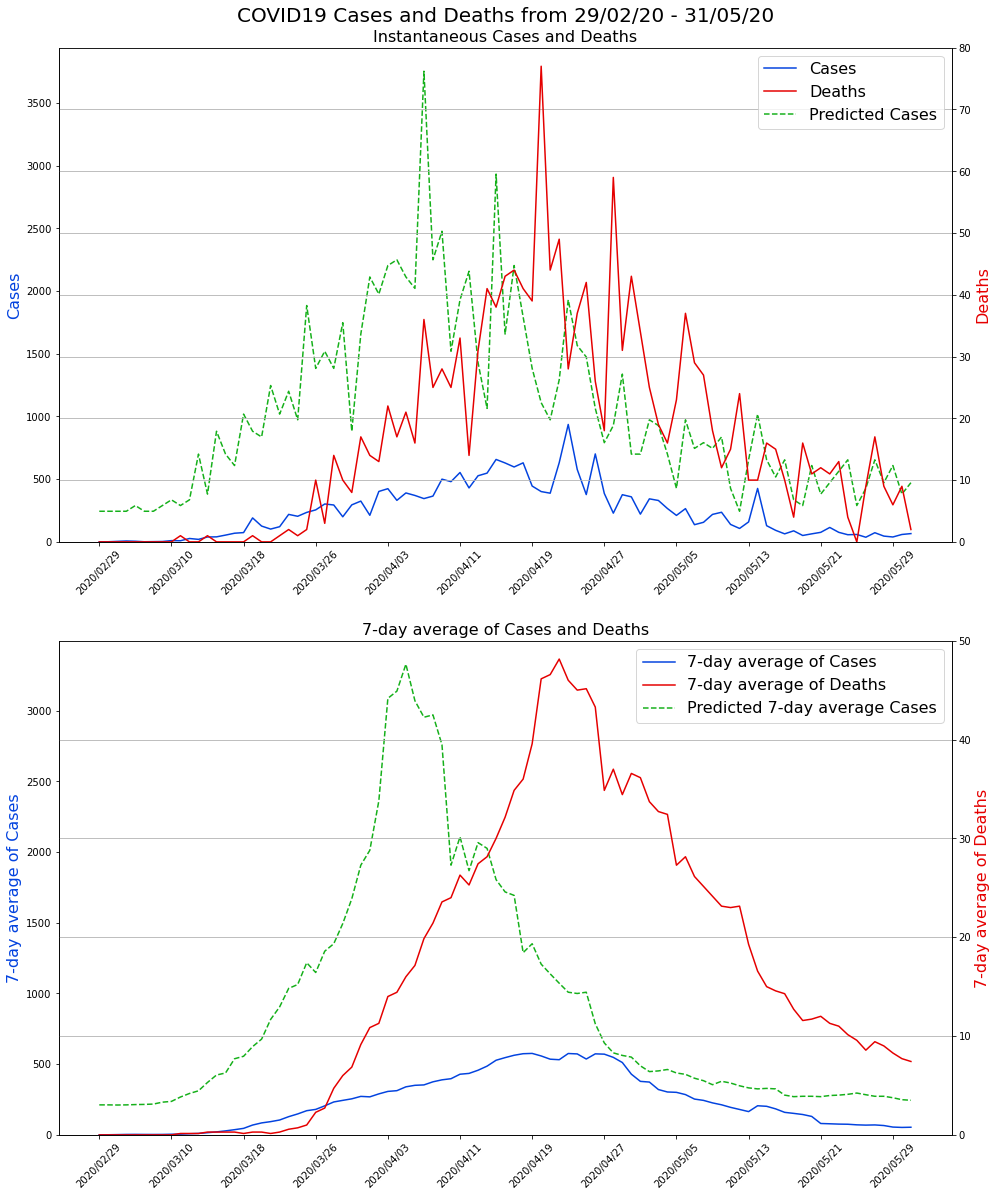

In [90]:
num_ticks = len(inst_test_df_shifted.index)//7 # Calculate number of ticks to give a tick at approximately every 1 week interval on the x axis.
fig,ax = plt.subplots(nrows = 2, ncols = 1, figsize=(16,20)) # Subplots to make 2 plots (nrows=2,ncols=1) with a figure size of 16x20.

# ==============================================
# First plot for instantaneous cases and deaths:
# ==============================================

cases_trace = ax[0].plot(inst_test_df.Cases.loc['2020/02/29':'2020/05/31'],color='xkcd:blue',label='Cases') # Plot Cases data. Dates are plot on the x axis as the dates are the index of the DF.
ax[0].set_ylabel('Cases',color='xkcd:blue',fontsize=16) # Set left hand yaxis label to 'Cases'.
ax[0].xaxis.set_major_locator(plt.MaxNLocator(num_ticks)) # Set the number of ticks on the x axis to num_ticks (ticks @ approx. 1 week intervals).
labels = ax[0].get_xticklabels() # Return tick labels (Dates) as an object so that they can be rotated.
ax[0].set_xticklabels(labels,rotation=45) # Rotate x axis labels @ 45 degrees.
ax[0].set_title('Instantaneous Cases and Deaths',fontsize=16) # Sub-title for 1st plot for the instantaneous cases and deaths.
LR_trace = ax[0].plot(inst_LR_preds,color='xkcd:green',label='Predicted Cases',linestyle='--')
ax[0].set_ylim(bottom=0) # Limit the y axis ('Cases') to start at 0.

ax2 = ax[0].twinx() # Create a second y axis on the right hand side of the plot using the same x axis.
deaths_trace = ax2.plot(inst_test_df.Deaths.loc['2020/02/29':'2020/05/31'],color='xkcd:red',label='Deaths') # Plot Deaths data, dates on x axis.
ax2.set_ylabel('Deaths',color='xkcd:red',fontsize=16) # Set right hand yaxis label to 'Deaths'.
xticks = ax2.xaxis.set_major_locator(plt.MaxNLocator(num_ticks)) # Limit number of ticks on x axis to num_ticks (~1 week intervals).
ax2.set_ylim(bottom=0,top=80) # Limit the right-hand y axis ('Deaths') to start at 0.
ax2.grid() # Plot a grid for the right hand y axis.
ax2.legend(cases_trace + deaths_trace + LR_trace, ['Cases','Deaths','Predicted Cases'], fontsize=16, loc='best') # Create legend for Cases and Deaths traces in the best location as determined by matplotlib.

plt.title('COVID19 Cases and Deaths from 29/02/20 - 31/05/20',fontsize=20,y=1.04) # Set major title for both plots. y=1.04 positions the title so that it doesn't overlap with the minor titles.

# ==================================================
# Second plot for 7-day average of cases and deaths:
# ==================================================

ave7_cases_trace = ax[1].plot(ave7_test_df.Cases.loc['2020/02/29':'2020/05/31'],color='xkcd:blue',label='Cases') # Plot 7-day average Cases data. Dates are plot on the x axis as the dates are the index of the DF.
ax[1].set_ylabel('7-day average of Cases',color='xkcd:blue',fontsize=16) # Set left hand yaxis label to '7-day average of Cases'.
ax[1].xaxis.set_major_locator(plt.MaxNLocator(num_ticks)) # Set the number of ticks on the x axis to num_ticks (ticks @ approx. 1 week intervals).
labels = ax[1].get_xticklabels() # Return tick labels (Dates) as an object so that they can be rotated.
ax[1].set_xticklabels(labels,rotation=45) # Rotate x axis labels @ 45 degrees.
ave_PR_trace = ax[1].plot(ave_PR_preds,color='xkcd:green',label='Predicted 7-day average Cases',linestyle='--')
ax[1].set_ylim(bottom=0) # Limit the left-hand y axis ('7-day average of Cases') to start at 0.
ax[1].set_title('7-day average of Cases and Deaths',fontsize=16) # Sub-title for 2nd plot for the 7-day average of cases and deaths.

ax2 = ax[1].twinx() # Create a second y axis on the right hand side of the plot using the same x axis.
ave7_deaths_trace = ax2.plot(ave7_test_df.Deaths.loc['2020/02/29':'2020/05/31'],color='xkcd:red',label='Deaths') # Plot 7-day average of Deaths data, dates on x axis.
ax2.set_ylabel('7-day average of Deaths',color='xkcd:red',fontsize=16) # Set right hand yaxis label to '7-day average of Deaths'.
ax2.set_ylim(bottom=0,top=50) # Limit the right-hand y axis ('7-day average of Deaths') to start at 0.
ax2.grid() # Plot a grid for the right hand y axis.
ax2.legend(ave7_cases_trace + ave7_deaths_trace + ave_PR_trace, ['7-day average of Cases','7-day average of Deaths','Predicted 7-day average Cases'], fontsize=16, loc='best') # Create legend for average Cases and Deaths traces in the best location as determined by matplotlib.
xticks = ax2.xaxis.set_major_locator(plt.MaxNLocator(num_ticks)) # Limit number of ticks on x axis to num_ticks (~1 week intervals).

plt.show()

# 16. Conclusion/Discussion

The linear regression model for actual cases and deaths and the poly regression model for the 7-day average both show a significant number of cases for 0 deaths at the beginning of the pandemic, which arises from the intercept term of the model. It is likely that the actual case numbers on 29/02/20 were much lower initially, and then rose as time went on.

It's possible that the model could've been improved by using alternative sources of data to expand the dataset - e.g. data from the UK. However, different Government regulations around COVID restrictions and their overall handling of the virus make this difficult - deaths due to COVID in the UK are far higher than Ireland with regards to their population size (~123k deaths for a population of ~65 million, as opposed to 4333 deaths for a population of ~5 million).